# Import des packages

In [1]:
import rasterio as ras
import matplotlib.pyplot as plt
import numpy as np
from rasterio.enums import Resampling
import mapclassify 
import geopandas as gpd
import folium
from sklearn.cluster import KMeans
from sklearn.impute import SimpleImputer
from shapely.geometry import shape
from rasterio.features import shapes
import geopandas as gpd


In [2]:
# Replace this with the actual path to your shapefile
shapefile_path = r"C:\Users\Flori\OneDrive - UniLaSalle\Cours 5A\Télédetection\zone_etude.shp"

# Read the shapefile using geopandas
gdf_shapefile = gpd.read_file(shapefile_path)

# Display the GeoDataFrame
gdf_shapefile.head()

,Id,geometry
0,0,"POLYGON ((485720.175 5366879.192, 503958.323 5..."


In [3]:
# Replace these with the actual paths to your raster files
red_band_path = r"C:\Users\Flori\OneDrive - UniLaSalle\Cours 5A\Télédetection\SENTINEL2X_20240915-000000-000_L3A_T31UDP_D_V3-0\SENTINEL2X_20240915-000000-000_L3A_T31UDP_C_V3-0\SENTINEL2X_20240915-000000-000_L3A_T31UDP_C_V3-0_FRC_B2.tif"
green_band_path = r"C:\Users\Flori\OneDrive - UniLaSalle\Cours 5A\Télédetection\SENTINEL2X_20240915-000000-000_L3A_T31UDP_D_V3-0\SENTINEL2X_20240915-000000-000_L3A_T31UDP_C_V3-0\SENTINEL2X_20240915-000000-000_L3A_T31UDP_C_V3-0_FRC_B3.tif"
blue_band_path = r"C:\Users\Flori\OneDrive - UniLaSalle\Cours 5A\Télédetection\SENTINEL2X_20240915-000000-000_L3A_T31UDP_D_V3-0\SENTINEL2X_20240915-000000-000_L3A_T31UDP_C_V3-0\SENTINEL2X_20240915-000000-000_L3A_T31UDP_C_V3-0_FRC_B4.tif"
nir_band_path = "SENTINEL2X_20240915-000000-000_L3A_T31UDP_D_V3-0\SENTINEL2X_20240915-000000-000_L3A_T31UDP_C_V3-0\SENTINEL2X_20240915-000000-000_L3A_T31UDP_C_V3-0_FRC_B8.tif"
swir_band_path = "SENTINEL2X_20240915-000000-000_L3A_T31UDP_D_V3-0\SENTINEL2X_20240915-000000-000_L3A_T31UDP_C_V3-0\SENTINEL2X_20240915-000000-000_L3A_T31UDP_C_V3-0_FRC_B11.tif"

In [4]:
with ras.open(red_band_path) as src_red:
  red_band = src_red.read(1)
with ras.open(green_band_path) as src_green:
  green_band = src_green.read(1)
with ras.open(blue_band_path) as src_blue:
  blue_band = src_blue.read(1)
with ras.open(nir_band_path) as src_nir:
  nir_band = src_nir.read(1)
  nir_profile = src_nir.profile
with ras.open(nir_band_path) as src_swir:
  swir_band = src_swir.read(1)
  swir_profile = src_swir.profile

In [5]:
from rasterio.mask import mask

# Crop the Red band to the shapefile
with ras.open(red_band_path) as src:
    red_band, red_transform = mask(src, gdf_shapefile.geometry, crop=True)
    red_meta = src.meta.copy()
    red_meta.update({
        "driver": "GTiff",
        "height": red_band.shape[1],
        "width": red_band.shape[2],
        "transform": red_transform
    })
red_band = np.squeeze(red_band, axis=0)

# Crop the Green band to the shapefile
with ras.open(green_band_path) as src:
    green_band, green_transform = mask(src, gdf_shapefile.geometry, crop=True)
    green_meta = src.meta.copy()
    green_meta.update({
        "driver": "GTiff",
        "height": green_band.shape[1],
        "width": green_band.shape[2],
        "transform": green_transform
    })
green_band = np.squeeze(green_band, axis=0)

# Crop the Blue band to the shapefile
with ras.open(blue_band_path) as src:
    blue_band, blue_transform = mask(src, gdf_shapefile.geometry, crop=True)
    blue_meta = src.meta.copy()
    blue_meta.update({
        "driver": "GTiff",
        "height": blue_band.shape[1],
        "width": blue_band.shape[2],
        "transform": blue_transform
    })
blue_band = np.squeeze(blue_band, axis=0)

# Crop the NIR band to the shapefile
with ras.open(nir_band_path) as src:
    nir_band, nir_transform = mask(src, gdf_shapefile.geometry, crop=True)
    nir_meta = src.meta.copy()
    nir_meta.update({
        "driver": "GTiff",
        "height": nir_band.shape[1],
        "width": nir_band.shape[2],
        "transform": nir_transform
    })
nir_band = np.squeeze(nir_band, axis=0)

# Crop the SWIR band to the shapefile
with ras.open(swir_band_path) as src:
    swir_band, swir_transform = mask(src, gdf_shapefile.geometry, crop=True)
    swir_meta = src.meta.copy()
    swir_meta.update({
        "driver": "GTiff",
        "height": swir_band.shape[1],
        "width": swir_band.shape[2],
        "transform": swir_transform
    })
swir_band = np.squeeze(swir_band, axis=0)

In [6]:
from rasterio.warp import reproject, Resampling

# Define the target shape and transform from the SWIR band
target_shape = swir_band.shape
target_transform = swir_transform

# Function to resample a band
def resample_band(band, src_transform, src_crs, target_transform, target_shape):
    resampled_band = np.empty(target_shape, dtype=band.dtype)
    reproject(
        source=band,
        destination=resampled_band,
        src_transform=src_transform,
        src_crs=src_crs,
        dst_transform=target_transform,
        dst_crs=src_crs,
        resampling=Resampling.bilinear
    )
    return resampled_band

# Resample the cropped bands
red_band = resample_band(red_band, red_transform, nir_profile['crs'], target_transform, target_shape)
green_band = resample_band(green_band, green_transform, nir_profile['crs'], target_transform, target_shape)
blue_band = resample_band(blue_band, blue_transform, nir_profile['crs'], target_transform, target_shape)
nir_band = resample_band(nir_band, nir_transform, nir_profile['crs'], target_transform, target_shape)

# Display the shapes of the resampled bands
print("Red band resampled shape:", red_band.shape)
print("Green band resampled shape:", green_band.shape)
print("Blue band resampled shape:", blue_band.shape)
print("NIR band resampled shape:", nir_band.shape)
print("SWIR band shape:", swir_band.shape)

Red band resampled shape: (912, 912)
Green band resampled shape: (912, 912)
Blue band resampled shape: (912, 912)
NIR band resampled shape: (912, 912)
SWIR band shape: (912, 912)


In [7]:
# Calculer le NDVI
ndvi = (nir_band - red_band) / (nir_band + red_band)

# Calculer le MNDWI
mndwi = (green_band - swir_band) / (green_band + swir_band)

# Calculer le EVI
evi = 2.5 * (nir_band - red_band) / (nir_band + 2.4 * red_band - 7.5 + 10000)

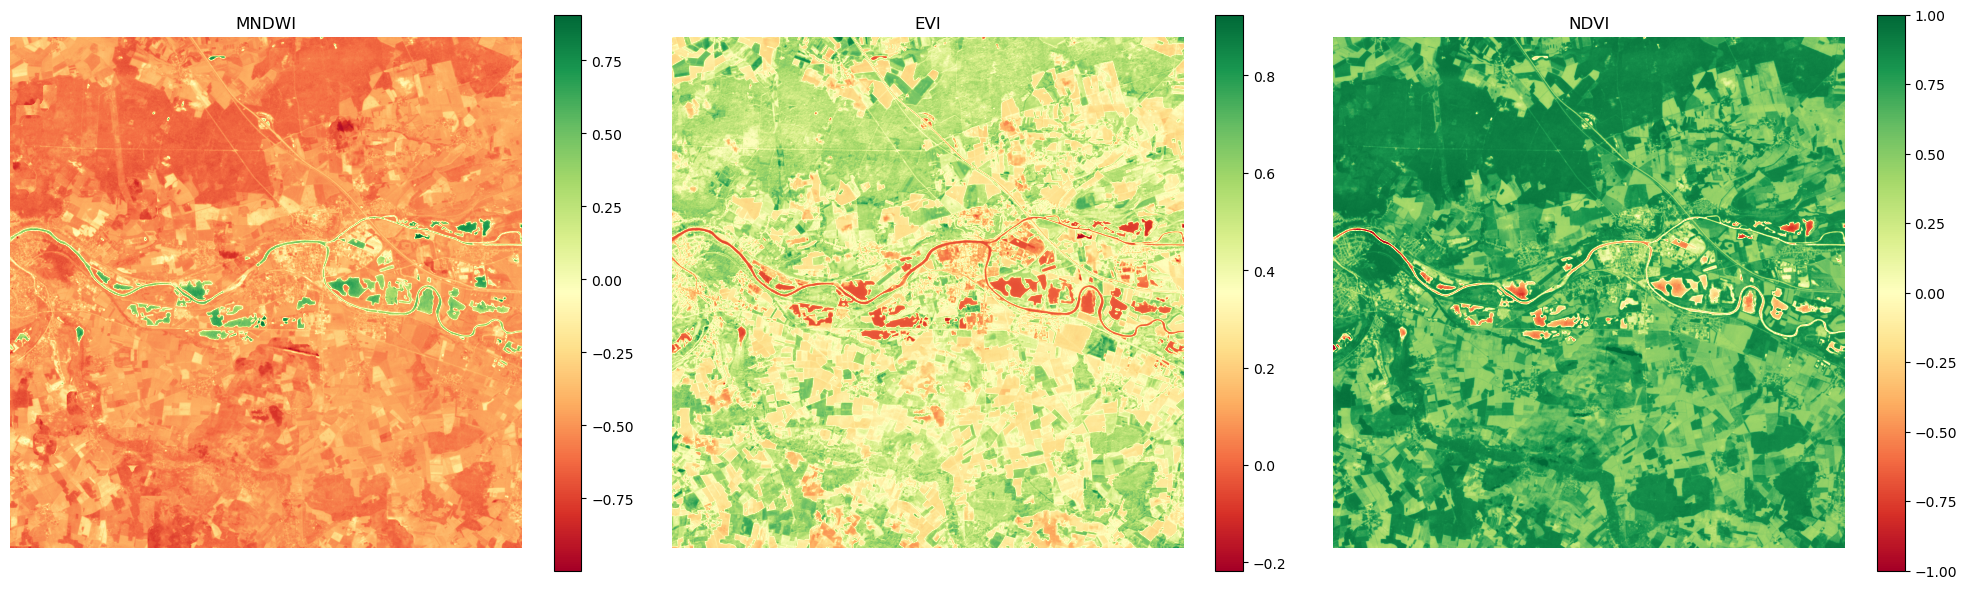

In [8]:

fig, axes = plt.subplots(1, 3, figsize=(20, 6))

# Plot MNDWI
axes[0].imshow(mndwi, cmap='RdYlGn')
axes[0].set_title('MNDWI')
axes[0].axis('off')
fig.colorbar(axes[0].images[0], ax=axes[0], orientation='vertical')

# Plot EVI
axes[1].imshow(evi, cmap='RdYlGn')
axes[1].set_title('EVI')
axes[1].axis('off')
fig.colorbar(axes[1].images[0], ax=axes[1], orientation='vertical')

# Plot NDVI
axes[2].imshow(ndvi, cmap='RdYlGn')
axes[2].set_title('NDVI')
axes[2].axis('off')
fig.colorbar(axes[2].images[0], ax=axes[2], orientation='vertical')

plt.tight_layout()
plt.show()
# Save the figure as a JPEG file
fig.savefig('indices_comparison.jpeg', format='jpeg')

In [9]:
# Create a mask for the conditions
mask = ((mndwi > ndvi) | (mndwi > evi)) & (evi < 0.1)

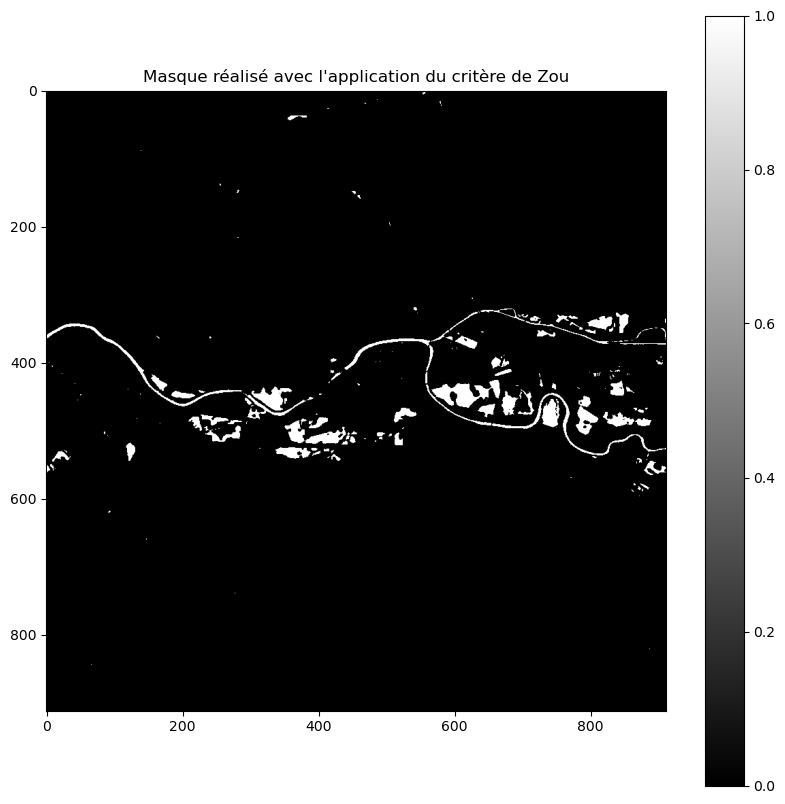

In [10]:
fig = plt.figure(figsize=(10, 10))
plt.imshow(mask, cmap='gray')
plt.title("Masque réalisé avec l'application du critère de Zou")
plt.colorbar()
fig.savefig('masque_critere_zou.jpeg', format='jpeg')
plt.show()

In [11]:
# Calculer les coordonnées minimales (min_x et min_y) du shapefile
min_x, max_y = gdf_shapefile.total_bounds[0], gdf_shapefile.total_bounds[3]

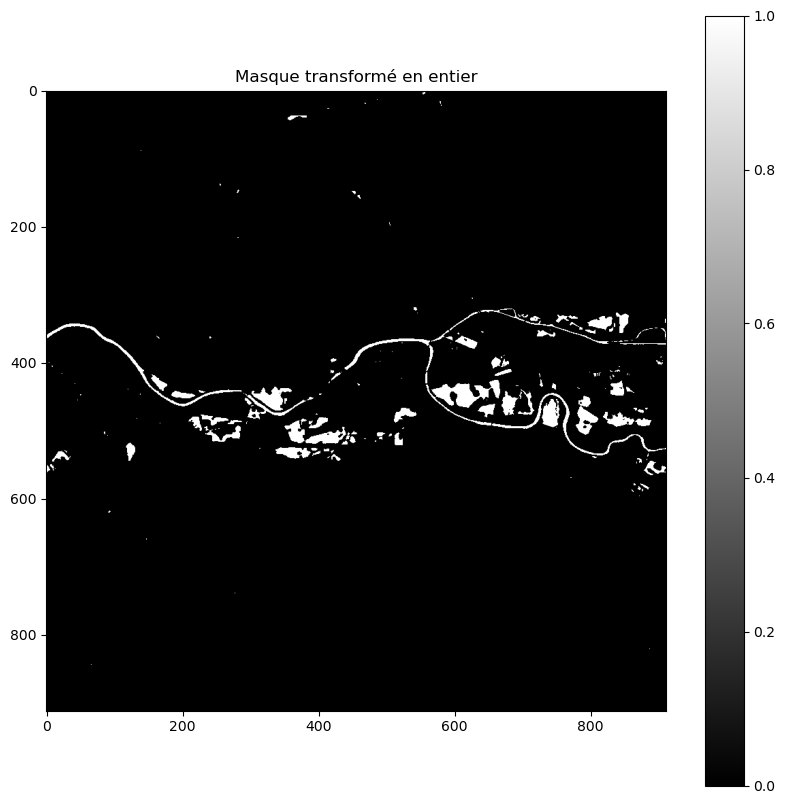

In [12]:
# Transform the boolean mask into an integer mask
mask_int = mask.astype(int)

# Display the transformed mask
plt.figure(figsize=(10, 10))
plt.imshow(mask_int, cmap='gray')
plt.title('Masque transformé en entier')
plt.colorbar()
plt.show()

In [13]:
# Assuming clustered_image is already defined
mask = (mask == 1).astype(np.uint8)
mask

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

In [14]:
from rasterio.transform import from_origin
# 2. Définir les métadonnées
# Remplacez ces valeurs par celles de votre contexte
west = min_x  # Coordonnée X de l'origine (coin supérieur gauche)
north = max_y  # Coordonnée Y de l'origine (coin supérieur gauche)
pixel_width = 20  # Résolution en X (taille d'un pixel en unités réelles)
pixel_height = 20  # Résolution en Y (taille d'un pixel en unités réelles)
transform = from_origin(west, north, pixel_width, pixel_height)

# Métadonnées à fournir à rasterio
meta = {
    "driver": "GTiff",  # Format de sortie
    "height": mask.shape[0],  # Nombre de lignes
    "width": mask.shape[1],  # Nombre de colonnes
    "count": 1,  # Nombre de bandes (ici 1 seule bande)
    "dtype": 'int8',  # Type des données (ex. int64)
    "crs": "EPSG:32631",  # Système de coordonnées (remplacez si nécessaire)
    "transform": transform,  # Transformation géospatiale
    "compress": None,  # Désactive la compression
}

# 3. Écrire l'image en tant que GeoTIFF
with ras.open('surfaces_eau_zou.tif', 'w', **meta) as dst:
    dst.write(mask_int, 1)  # Écrire le tableau dans la première bande

# 4. Lire le fichier enregistré pour vérification ou analyses
with ras.open('surfaces_eau_zou.tif') as src_im_cla:
    print("Informations sur l'image chargée :")
    print(src_im_cla)
    print("Dimensions :", src_im_cla.width, "x", src_im_cla.height)
    print("Nombre de bandes :", src_im_cla.count)

Informations sur l'image chargée :
<open DatasetReader name='surfaces_eau_zou.tif' mode='r'>
Dimensions : 912 x 912
Nombre de bandes : 1


# Traitements

In [23]:
from rasterio.features import shapes
from shapely.geometry import shape

# Open the raster file
with ras.open('surfaces_eau_zou.tif') as src:
    image = src.read(1)  # Read the first band
    mask = image == 1  # Create a mask where the value is 1
    results = (
        {'properties': {'raster_val': v}, 'geometry': s}
        for i, (s, v) in enumerate(
            shapes(image, mask=mask, transform=src.transform)))

# Convert shapes to GeoDataFrame
geoms = list(results)
gdf_surfaces_eau = gpd.GeoDataFrame.from_features(geoms)
gdf_surfaces= gdf_surfaces_eau.copy()
# Set the CRS
gdf_surfaces_eau.crs = src.crs

# Display the GeoDataFrame
gdf_surfaces_eau.head()

,geometry,raster_val
0,"POLYGON ((496820.175 5366859.192, 496820.175 5...",1.0
1,"POLYGON ((495440.175 5366639.192, 495440.175 5...",1.0
2,"POLYGON ((497280.175 5366579.192, 497280.175 5...",1.0
3,"POLYGON ((495080.175 5366539.192, 495080.175 5...",1.0
4,"POLYGON ((497320.175 5366479.192, 497320.175 5...",1.0


In [24]:
# Simplify the geometries using buffer method with dissolve
gdf_surfaces_eau['geometry'] = gdf_surfaces_eau.buffer(15)
gdf_surfaces_eau = gpd.GeoDataFrame(geometry=[gdf_surfaces_eau.unary_union], crs=gdf_surfaces_eau.crs)
gdf_surfaces_eau['geometry'] = gdf_surfaces_eau.buffer(-15)

gdf_surfaces_eau

C:\Users\Flori\AppData\Local\Temp\ipykernel_26976\3013425710.py:3: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  gdf_surfaces_eau = gpd.GeoDataFrame(geometry=[gdf_surfaces_eau.unary_union], crs=gdf_surfaces_eau.crs)


,geometry
0,"MULTIPOLYGON (((503900.192 5360059.209, 503900..."


In [17]:
# Split the multipolygons into individual polygons
gdf_polygons = gdf_surfaces_eau.explode(index_parts=True).reset_index(drop=True)

# Display the new GeoDataFrame
gdf_polygons

,geometry
0,"POLYGON ((503900.192 5360059.209, 503900.175 5..."
1,"POLYGON ((503780.192 5359879.209, 503780.175 5..."
2,"POLYGON ((502580.192 5359439.209, 502580.175 5..."
3,"POLYGON ((503280.192 5355699.209, 503280.175 5..."
4,"POLYGON ((503940.192 5355419.209, 503940.175 5..."
...,...
184,"POLYGON ((485840.192 5355839.209, 485840.175 5..."
185,"POLYGON ((485980.192 5355759.209, 485980.175 5..."
186,"POLYGON ((485880.192 5358779.209, 485880.175 5..."
187,"POLYGON ((485720.192 5355639.209, 485720.175 5..."


In [18]:
# Simplify the geometries in gdf_polygons
gdf_polygons['geometry'] = gdf_polygons['geometry'].simplify(tolerance=20, preserve_topology=True)

# Display the updated GeoDataFrame
gdf_polygons.head()

,geometry
0,"POLYGON ((503900.192 5360059.209, 503900.192 5..."
1,"POLYGON ((503780.192 5359879.209, 503860.157 5..."
2,"POLYGON ((502580.192 5359439.209, 503959.806 5..."
3,"POLYGON ((503280.192 5355699.209, 503400.192 5..."
4,"POLYGON ((503940.192 5355419.209, 503940.192 5..."


In [19]:
# Calculate the area of each polygon and create a new column 'area'
gdf_polygons['area'] = gdf_polygons['geometry'].area

# Display the updated GeoDataFrame
gdf_polygons.head()

,geometry,area
0,"POLYGON ((503900.192 5360059.209, 503900.192 5...",7793.448903
1,"POLYGON ((503780.192 5359879.209, 503860.157 5...",19074.835825
2,"POLYGON ((502580.192 5359439.209, 503959.806 5...",40167.788456
3,"POLYGON ((503280.192 5355699.209, 503400.192 5...",115194.204532
4,"POLYGON ((503940.192 5355419.209, 503940.192 5...",398.621761


In [25]:
# Create a map centered around the geometries using explore()
m = gdf_polygons.explore(name="Surfaces d'eau traitées", tiles="OpenStreetMap", zoom_start=12)

# Add gdf_surfaces_eau layer
gdf_surfaces.explore(m=m, name="Surfaces d'eau non traitées")

# Add layer control
folium.LayerControl().add_to(m)

# Save the map as an HTML file
m.save('map.html')

# Display the map
m
